The purpose of this notebook is to explore plotting drifters in each region, colour by drifter type.

In [1]:

import json
import yaml

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import patches
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.stats import bootstrap
import xarray as xr


from driftutils.assemble_drifter_metadata import assemble_drifter_metadata

%matplotlib inline

In [2]:
data_dir = '/home/jmm000/work/Drifters/output/TechReport2023/netcdf/'

In [3]:
assemble_drifter_metadata(data_dir, 'all_drifters.json')

In [4]:
with open('all_drifters.json', 'r') as f:
    metadata = json.load(f)

## Now explore plotting the regions

In [5]:
def load_polygon_coordinates(filename):
    '''Load the poylgon coordinate file and return a dictionary 
    with the shaplel Polygon for each region defined in the 
    coordinate file'''

    with open(filename, 'r') as f:
        poly_coords = yaml.safe_load(f)
    regions = {}
    for region in poly_coords['polygon_coords']:
        coords = poly_coords['polygon_coords'][region]
        new_coords = [(lon, lat) for lat, lon in coords ]
        regions[region] = Polygon(new_coords)
    return regions

In [6]:
def identify_drifters_region(region, metadata):
    drifters  = []
    for d in metadata['drifters']:
        launch_lat = float(d['first_latitude_observation'])
        launch_lon = float(d['first_longitude_observation'])
        launch_coord = Point((launch_lon, launch_lat))
        if launch_coord.within(region):
            drifters.append(d['filename'])
    return drifters

In [7]:
def compile_drifters(drifter_files):
    """Compile drifters in """
    drifters = pd.DataFrame()
    for drifter_file in drifter_files:
        d = xr.open_dataset(drifter_file)
        new_drifter = pd.DataFrame(d.attrs, index=[0,])
        # Determine if drifter ends at Sea or at land
        if d.ATSEA[-1] == 3:
            ends = 'ends at Sea'
        elif (d.ATSEA[-1] == 1) or (d.ATSEA[-1]) == 2:
            ends = 'ends on Land'
        else:
            ends = 'unknown'
        new_drifter['EndPosition'] = ends
        drifters = pd.concat([drifters, new_drifter])
    drifters = drifters.reset_index()
    drifters = drifters.drop(columns='index')

    
    return drifters

In [8]:
regions = load_polygon_coordinates('drifter-regions.yaml')
all_drifters = pd.DataFrame()
for region in regions:
    poly = regions[region]
    drifter_files = identify_drifters_region(poly, metadata)
    drifters = compile_drifters(drifter_files)
    drifters['Region'] = region
    all_drifters = pd.concat([all_drifters, drifters], ignore_index=True)
all_drifters = all_drifters.reset_index()
all_drifters = all_drifters.drop(columns='index')

In [9]:
def plot_patches(ax, xmin, width1, ymin1, height1, args1, width2, ymin2, height2, args2):
    # Firstt patch
    ax.add_patch(patches.Rectangle(
        xy=(xmin, ymin1),  # point of origin.
        width=width1,
        height=height1,
        zorder=0,
        **args1))
    # Add whitepatch first to avoid overlapping alphas
    ax.add_patch(patches.Rectangle(
        xy=(xmin+width2/2, ymin2),  # point of origin.
        width=width2,
        height=height2,
        zorder=0,
        color='white'))
    # Second patch
    ax.add_patch(patches.Rectangle(
        xy=(xmin+width2/2, ymin2),  # point of origin.
        width=width2,
        height=height2,
        zorder=0,
        **args2))

In [10]:
def plot_distribution(all_drifters, metric, ylabel):
    """Plot distribution with three groupings: Region, type, and EndPosition"""
    fig,axs = plt.subplots(1,3, figsize=(10,8), sharey=True)
    
    # Some constants and plot settings
    width = .035 # width of bars on distribution
    medianprops={'color':'purple', 'linestyle': '-', 'lw': 3}
    meanprops={'color':'red', 'linestyle': '-', 'lw': 2}
    whiskerprops={'linewidth': 0}
    stdargs={'facecolor': 'r', 
             'edgecolor': 'r',
             'alpha': 0.3,}
    ciargs={'facecolor': 'b', 
            'edgecolor': 'b',
            'alpha': 0.3,}
    
    # Setting up legend handles
    handles=[]
    handles.append(Line2D([0], [0], label='Median', **medianprops))
    handles.append(Line2D([0], [0], label='Mean', **meanprops))
    handles.append(Patch(label = 'Standard deviation', **stdargs))
    handles.append(Patch(label = '2.5 to 97.5 percentile\nrange', **ciargs))
    
    for group, ax in zip(['Region', "EndPosition", 'type'], axs):
        
        print(group)
        
        grouped = all_drifters.groupby(group)
        print(grouped.describe(percentiles=[.025, .25, .50, .75, .975])[metric])
        num_groups= len(grouped)
        
        # Scaling the bar width since some axes have fewer bars
        # the result is all axes have the same bar width
        axis_width = ax.get_window_extent().width
        adj_width = 1/(axis_width*width/num_groups)

        d = all_drifters.boxplot(
            column=[metric], showmeans=True, 
            by=group, ax=ax, showfliers=False,showcaps=False, showbox=False,
            meanline=True, widths=adj_width,
            medianprops=medianprops,
            meanprops=meanprops,
            whiskerprops=whiskerprops,
            rot=70,fontsize=14)
    

        for label in d.get_xticklabels():
            y = all_drifters[metric][
                all_drifters[group]==label.get_text()].dropna()
            # Add some random "jitter" to the x-axis
            x = np.random.normal(label.get_position()[0],
                                 0.03, size=len(y))
            ax.plot(x, y, 'k.', alpha=0.5, ms=2)
            # Adding rectangles for confidence intervals and std
            min_x = label.get_position()[0] - adj_width/2
            data = (grouped.get_group(label.get_text())[metric].values,)
            # 95% confidence intervals
            ci = np.percentile(data,[2.5,97.5])
            min_y_ci = ci[0]
            ci_height = ci[-1] - ci[0]
            # std
            std = all_drifters[metric][all_drifters[group]==label.get_text()].describe()['std']
            mean = all_drifters[metric][all_drifters[group]==label.get_text()].describe()['mean']
            count = all_drifters[metric][all_drifters[group]==label.get_text()].describe()['count']
            if count > 2:
                # only plot std and percentile range if enough data
                min_y_std = mean-std
                std_height = 2*std
                #if ci_height > std_height:
                plot_patches(ax,
                                 min_x, adj_width,
                                 min_y_ci, ci_height, ciargs,
                                 adj_width/2, min_y_std, std_height, stdargs)
                #else:
                #    plot_patches(ax,
                #                 min_x, adj_width/2,
                #                 min_y_std, std_height, stdargs,
                #                 adj_width, min_y_ci, ci_height, ciargs)
        
        ax.set_ylim([0, ax.get_ylim()[-1]])
        ax.set_xlabel('')
        ax.set_title('')
        print()
    axs[1].legend(handles=handles, bbox_to_anchor=(.97,1.45),fontsize=12)
    axs[0].set_ylabel(ylabel,fontsize=16)
    fig.suptitle('')
    fig.set_tight_layout(True)

    return fig

Region
                      count        mean         std        min       2.5%  \
Region                                                                      
Bay of Fundy           45.0   46.143368   66.668258   0.533241   1.794740   
Gulf of St. Lawrence   64.0   44.880325   69.377785   0.731250   5.642399   
Laurentian Channel     16.0   54.793547   22.832298  13.247222  14.185764   
Newfoundland Shelf     34.0  103.381586  162.710821   0.071910   0.139132   
Scotian Shelf          61.0  102.788963  171.972767   0.750000   1.183356   

                            25%        50%         75%       97.5%         max  
Region                                                                          
Bay of Fundy           7.158333  25.011586   59.205556  262.892917  306.999306  
Gulf of St. Lawrence  19.761606  28.179890   49.885990   91.660990  560.318056  
Laurentian Channel    49.642396  64.738709   68.910926   77.947743   79.518056  
Newfoundland Shelf     3.243238  11.173270  101.

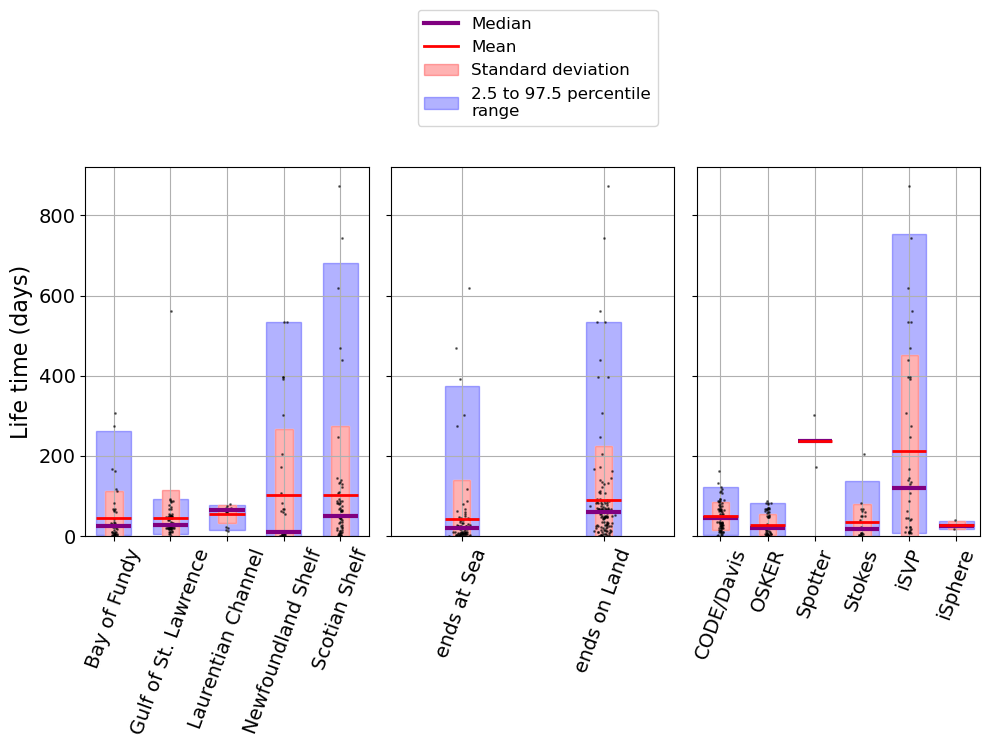

In [11]:
fig = plot_distribution(all_drifters, 'duration_days', 'Life time (days)')
fig.savefig('duration_days_summary.png', bbox_inches='tight', dpi=500)

Region
                      count         mean          std         min        2.5%  \
Region                                                                          
Bay of Fundy           45.0  2237.086748  4305.394446   25.081838   83.788405   
Gulf of St. Lawrence   64.0  1349.924246  1933.799526    8.634194  296.811103   
Laurentian Channel     16.0  1428.236380   626.191349  282.954285  338.826637   
Newfoundland Shelf     34.0  2656.004497  3927.907325    0.605658    1.301827   
Scotian Shelf          61.0  2820.911229  4714.161303    5.482422   17.890082   

                             25%          50%          75%         97.5%  \
Region                                                                     
Bay of Fundy          297.797942  1005.496666  1780.682647  12293.363052   
Gulf of St. Lawrence  746.358114   934.108239  1537.782929   2377.289397   
Laurentian Channel    958.617287  1648.970261  1880.217634   2229.859658   
Newfoundland Shelf     80.315565   197.361557

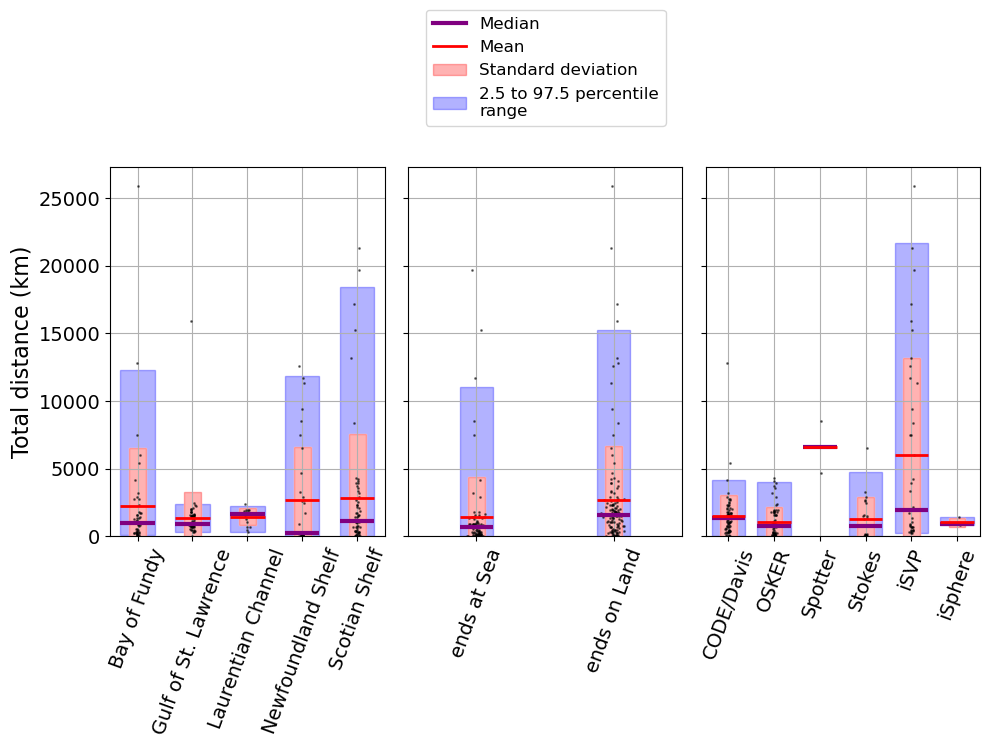

In [12]:
fig = plot_distribution(all_drifters, 'distance_km', 'Total distance (km)')
fig.savefig('distance_km_summary.png', bbox_inches='tight', dpi=500)

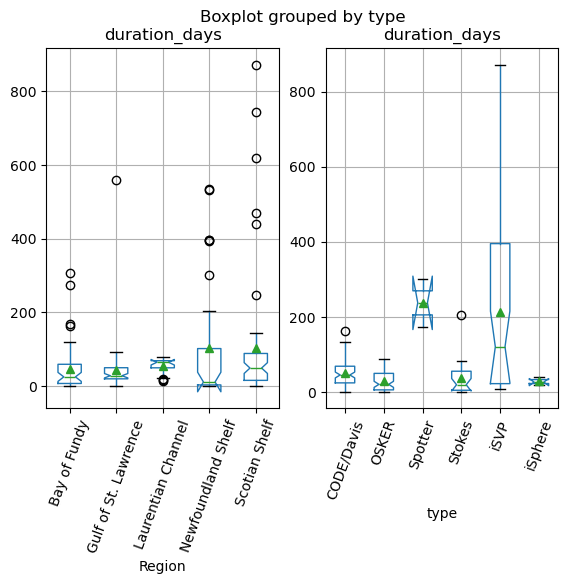

In [13]:
fig,axs = plt.subplots(1,2)
metric = 'duration_days'
for group, ax in zip(['Region', 'type'], axs):

    d = all_drifters.boxplot(column=[metric], showmeans=True, 
                             by=group, ax=ax,
                             notch=True,
                             rot=70)

In [14]:
print(all_drifters.describe()['duration_days'])
print(all_drifters.describe()['distance_km'])

count    220.000000
mean      70.957226
std      123.268472
min        0.071910
25%       12.235035
50%       33.703819
75%       68.313903
max      872.232639
Name: duration_days, dtype: float64
count      220.000000
mean      2146.798070
std       3692.161627
min          0.605658
25%        349.820815
50%       1044.873009
75%       1931.549135
max      25877.914069
Name: distance_km, dtype: float64


## To Dos
1. Confirm with Justine method for identifying if drifters end at sea (ATSEA[-1] = 1,2) or on land (ATSEA[-1] = 3)
2. Reconsider 95% confidence intervals - should we plot the 2.5/97.5 percentiles of the distribution OR should we plot the 95% bootstrapped confidence intervals of the mean (median)??
  * To be consistent with Roy, I think it is the former
3. Print/format tables with the statisitics.